# Amazon Fraud Detector from End to End for Account Takeover Insights 
### Un-supervised fraud detection  
-------
- [Introduction](#Introduction)
- [Data preparation](#Data_preparation)
- [Set up AWS credentials & permissions](#Set_up_AWS_credentials_permissions)
- [Plan](#Plan)


## Introduction
-------

Amazon Fraud Detector (AFD) is a fully managed service that makes it easy to identify potentially fraudulent online activities such as online payment fraud, creation of fake accounts, and account takeovers. Fraud Detector capitalizes on the latest advances in machine learning (ML) and 20 years of fraud detection expertise from AWS and Amazon.com to automatically identify potentially fraudulent activities so you can catch more fraud faster. 

In this notebook, we'll use the Amazon Fraud Detector API to define an entity and an event of interest and send events to AFD from a CSV file stored in S3. Next, we'll train a model with Account Takeover Insight template using the events we have sent. After that, we'll derive some rules and create a "detector" by combining our entity, event, model, and rules into a single endpoint. Finally, we'll apply the detector to a sample of our data to identify potentially fraudulent events.

After running this notebook you should be able to: 

- Define an Entity and an Event
- Send Events to AFD
- Train a Machine Learning (ML) Model
- Author Rules to identify potential fraud based on the model's score
- Create a Fraud Detector
- Apply the Detector's "predict" function, to generate a model score and rule outcomes on data  

If you would like to know more, please check out [Fraud Detector's Documentation](https://docs.aws.amazon.com/frauddetector/). 


## Data preparation <a id='Data_preparation'></a>
------

Before you train a Transaction Fraud Insights model, ensure that you have stored at least 10,000 records in your training dataset within Amazon Fraud Detector. We recommend that you collect at least 3-6 weeks of historic data with at least 1,500 unique entities. The Transaction Fraud Insights model will calculate aggregates likes account’s age, transaction counts based on the account’s history. Therefore, providing the full history of the accounts will help the model to calculate the aggregates correctly to capture the fraud patterns.

In addition to the event variables, the training dataset must contain the following headers:
* ENTITY_TYPE - Who is performing the activity, e.g. customer. Currently, AFD only support one ENTITY_TYPE per EVENT_TYPE. That column should contain a single value. 
* ENTITY_ID - An identifier for who is performing the activity, e.g. customer id
* EVENT_ID - An identifier for the event, e.g. order id
* EVENT_TIMESTAMP - The timestamp of when the event occurred. The timestamp must be in ISO 8601 standard in UTC.
* EVENT_LABEL - Classifies the event as fraudulent or legitimate. The values in the column must correspond to the values defined in the event type.
* LABEL_TIMESTAMP - Timestamp of when the label is updated. LABEL_TIMESTAMP is required if EVENT_LABEL is included. If you do not have that data, you can duplicate the EVENT_TIMESTAMP column and rename it as LABEL_TIMESTAMP.



## Set up AWS credentials & permissions <a id='Set_up_AWS_credentials_permissions'></a>
----

https://docs.aws.amazon.com/frauddetector/latest/ug/set-up.html

To use Amazon Fraud Detector, you have to set up permissions that allow access to the Amazon Fraud Detector console and API operations. You also have to allow Amazon Fraud Detector to perform tasks on your behalf and to access resources that you own. We recommend creating an AWS Identify and Access Management (IAM) user with access restricted to Amazon Fraud Detector operations and required permissions. You can add other permissions as needed.

The following policies provide the required permission to use Amazon Fraud Detector. If you are using SageMaker Notebook Instance, add the following two policies to the Instance's IAM role and restart your kernel:

- *AmazonFraudDetectorFullAccessPolicy*  
    Allows you to perform the following actions:  
        - Access all Amazon Fraud Detector resources  
        - List and describe all model endpoints in Amazon SageMaker  
        - List all IAM roles in the account  
        - List all Amazon S3 buckets  
        - Allow IAM Pass Role to pass a role to Amazon Fraud Detector  

- *AmazonS3FullAccess*  
    Allows full access to Amazon S3. This is required to upload training files to S3.
    
    
    
## Plan
------
A *Detector* contains the event, model(s) and rule(s) for a particular type of fraud that you want to detect. We'll use the following 8 steps to plan a Fraud Detector:

1. [Setup notebook](#setup_notebook)<br>
    a. Name the major components: Event, Entity, Model, Detector <br>
    b. Specify the MODEL_TYPE you want to train <br>
    c. Plug in your S3 Bucket and CSV File
    
2. [Load and profile your dataset](#load_and_profile_your_data)<br>
    a. This will give you an idea of what your dataset contains<br>
    b. This will also identify the variables and labels that will need to be created to define your event

3. [Create event variables and labels](#create_event_variables_and_labels)<br>
    a. This will create the variables and labels in fraud detector 

4. [Define your Entity and Event Type](#define_your_entity_and_event_type)<br>
    a. What is activity that you are detecting? That's likely your Event Type (e.g. transaction)<br>
    b. Who is performing this activity? That's likely your Entity (e.g. customer)

5. [Send events](#send_events)<br>
    a. This will ingest your events to AFD 
     
6. [Create and train your model](#create_and_train_your_model)	
    a. Model training takes anywhere from 45-60 minutes. Once complete you need to promote your endpoint<br>
    b. Promote your model

7. [Create a Fraud Detector, generate Rules and assemble your Detector](#create_detector)<br>
    a. Create your detector<br>
    b. Define outcomes, e.g. fraud, investigate and approve<br>
    c. Create rules based on your model scores <br>
    d. Assemble your detector: combine your rule(s) and model into a "detector"

8. [Make predictions](#make_predictions)<br>
    a. Interactively call predict API on a handful of records   

In [1]:
# -- check boto3 version, if it is lower than 1.18.59, update it and restart the kernel --
import boto3
import os

current_boto3_version = boto3.__version__
print('Current boto3 version:', current_boto3_version)

if current_boto3_version < '1.24.36':
    print('update boto3...')
    %pip install 'boto3>=1.24.36'
    os._exit(00)          

Current boto3 version: 1.24.36


In [2]:
# -- import packages --
import boto3
import time
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from multiprocessing import Pool
from datetime import datetime, date
from dateutil.relativedelta import relativedelta
import csv, codecs
from sklearn.metrics import roc_curve, roc_auc_score, auc, roc_auc_score

# -- for display --
from IPython.core.display import display, HTML
from IPython.display import clear_output
display(HTML("<style>.container { width:90% }</style>"))
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
%matplotlib inline 

In [3]:
# -- initialize the AFD client --
client = boto3.client('frauddetector')

### 1. Setup notebook <a id='setup_notebook'></a>
-----

***To get started***

1. Name the major components of Fraud Detector
2. Specify the MODEL_TYPE you want to train: ACCOUNT_TAKEOVER_INSIGHTS. 
2. Plug in your S3 Bucket and CSV file path

Then you can interactively exeucte the code cells in the notebook, no need to change anything unless you want to. 


<div class="alert alert-info"> <strong> Major Fraud Detector Components </strong>
    
- **EVENT_TYPE** is a business activity that you want evaluated for fraud risk 
- **ENTITY_TYPE** represents the "what or who" that is performing the event you want to evaluate
- **MODEL_NAME** is the name of your supervised machine learning model that Fraud Detector trains on your behalf
- **DETECTOR_NAME** is the name of the detector that contains the detection logic (model and rules) that you apply to events that you want to evaluate for fraud

</div>


Identify the following assets:

<div class="alert alert-info"><strong>  Bucket, File and ARN Role</strong>

- **S3_BUCKET** is the name of the bucket where your file lives
- **S3_FILE** is the URL to your s3 file
- **ARN_ROLE** is the role Fraud Detector use to access your data in s3 bucket

</div>


_**Note**: To use Amazon Fraud Detector, you have to set up permissions that allow access to the Amazon Fraud Detector console and API operations. You also have to allow Amazon Fraud Detector to perform tasks on your behalf and to access resources that you own. We recommend creating an AWS Identify and Access Management (IAM) user with access restricted to. Amazon Fraud Detector operations and required permissions. You can add other permissions as needed. See "Create an IAM User and Assign Required Permissions" in the user's guide: https://docs.aws.amazon.com/frauddetector/latest/ug/set-up.html_

<div class="alert alert-block alert-danger">
<b>Update following section:</b> Define event, model, detector names, and data location
</div>

In [4]:
# -- this is all you need to fill out, once complete simply interactively run each code cell --  
EVENT_TYPE     = "your_event_name"
EVENT_DESC     = "your event description"

MODEL_NAME     = "your_model_name"
MODEL_DESC     = "your model description"

DETECTOR_NAME  = "your_detector_name"                       
DETECTOR_DESC  = "your detector description"

MODEL_TYPE     = "ACCOUNT_TAKEOVER_INSIGHTS"           

S3_BUCKET      = "your-s3-bucket-with-data"              
S3_FILE        = "path-to-your-data-file"                 
ARN_ROLE       = "your-arn-role"

# -- percentage of data used in model training (by default: 80%). 
TRAINING_PERC = 0.8  

### Header names in your CSV files

In [5]:
s3   = boto3.resource('s3')
obj  = s3.Object(S3_BUCKET, S3_FILE)
body = obj.get()['Body']
reader = csv.DictReader(codecs.getreader("utf-8")(body))
header_names = reader.fieldnames
for item in header_names:
    print(item)

EVENT_ID
ENTITY_ID
ENTITY_TYPE
EVENT_TIMESTAMP
EVENT_LABEL
LABEL_TIMESTAMP
ip
useragent
fp
session_id
are_credentials_valid


### Map header names to mandatory/optional variable types

<div class="alert alert-block alert-danger">
<b>Update following section:</b> Fill the mapping with CSV header names printed above. 
</div>

In [ ]:
# -- map your data to the variable types --
# Except the fixed-naming columns (EVENT_ID, ENTITY_ID, ENTITY_TYPE, EVENT_TIMESTAMP), use the VARIABLES_MAP dictionary 
# to map the variable type to the column names in your data.
# Mandatory variable types include: IP_ADDRESS, USERAGENT, ARE_CREDENTIALS_VALID
# Optional variable types: FINGERPRINT, SESSION_ID

VARIABLES_MAP = {
    # Mandatory variables
    "IP_ADDRESS": "ip",               # e.g. ip
    "USERAGENT": "useragent",                # e.g. user_agent
    "ARE_CREDENTIALS_VALID": "are_credentials_valid",    # e.g. are_credentials_valid
    
    # Optional variables
    "FINGERPRINT": "fp",              # e.g. fingerprint
    "SESSION_ID": "session_id"                # e.g. session_id
}

for c in VARIABLES_MAP.keys():
    if VARIABLES_MAP[c]!="" and VARIABLES_MAP[c] not in header_names:
        raise ValueError(f'Variable {VARIABLES_MAP[c]} (type {c}) not in CSV header!')

### 2. Load and profile your dataset <a id='load_and_profile_your_data'></a>
-----

The functions below will: 1) profile your data, creating descriptive statististics, 2) perform basic data quality checks (nulls, unique variables, etc.), and 3) return summary statistics and the EVENT and MODEL schemas used to define your EVENT_TYPE and train your model. 


_**Important Note**: The functions below provides a layman guess for the fraud/legit labels and variable mapping. Please review the summary stats, event variables, event labels and training data schema and make sure they are aligned with how you want to use the data. You can always manually modify them if needed._

<div class="alert alert-info"> 💡 <strong> summary stats, event variables, event labels and training data schema </strong>

- summary stats: data quality and summary statistics of the data; used to create variables of the specific feature types
- event variables: variables associated with the specific event type; used when creating event type and sending events
- event labels: labels associated with the event type; used when creating event type
- training data schema: define the variables to build the model, labels to be used as fraud/legit, and how to treat the unlabeled events; By default, we identify the rare event as fraud, and the rest as not-fraud. If you have more than 2 labels in the data or want to map them in a different way, you can manually modify the training data schema 

</div>



In [20]:
# --- no changes; just run this code block ---
def summary_stats(df, variables_map):
    """
    Generate summary statistics for a pandas data frame  
    """
    rowcnt = len(df)
    
    # -- calculating data statistics and data types -- 
    df_s1  = df.agg(['count', 'nunique']).transpose().reset_index().rename(columns={"index":"feature_name"})
    df_s1["null"] = (rowcnt - df_s1["count"]).astype('int64')
    df_s1["not_null"] = rowcnt - df_s1["null"]
    df_s1["null_pct"] = df_s1["null"] / rowcnt
    df_s1["nunique_pct"] = df_s1['nunique']/ rowcnt

    dt = pd.DataFrame(df.dtypes).reset_index().rename(columns={"index":"feature_name", 0:"dtype"})
    df_stats = pd.merge(dt, df_s1, on='feature_name', how='inner').round(4)
    df_stats['nunique'] = df_stats['nunique'].astype('int64')
    df_stats['count'] = df_stats['count'].astype('int64')
    
    
    # -- variable type mapper: map mandatory variables and variables_map  -- 
    flatten_var_maps = []
    for vartype in variables_map.keys():
        if isinstance(variables_map[vartype], list):
            for var in variables_map[vartype]:
                flatten_var_maps.append([vartype, var])
        else:
            flatten_var_maps.append([vartype, variables_map[vartype]])
            
    for vartype in ['ENTITY_TYPE','ENTITY_ID','EVENT_ID','EVENT_TIMESTAMP']:
        flatten_var_maps.append([vartype, vartype])
    for vartype in ['EVENT_LABEL','LABEL_TIMESTAMP']:
        if vartype in df.columns:
            flatten_var_maps.append([vartype, vartype])

    df_schema = pd.DataFrame(flatten_var_maps, columns = ['feature_type', 'feature_name'])
    df_stats = pd.merge(df_stats, df_schema, how = 'left', on = 'feature_name')
    
    # -- variable type mapper: map the rest types based on data type -- 
    df_stats.loc[(df_stats['feature_type'].isna())&(df_stats["dtype"] == object), 'feature_type'] = "CATEGORICAL"
    df_stats.loc[(df_stats['feature_type'].isna())&((df_stats["dtype"] == "int64") | (df_stats["dtype"] == "float64")), 'feature_type'] = "NUMERIC"
    
    # -- variable validation -- 
    df_stats['feature_warning'] = "NO WARNING"
    df_stats.loc[(df_stats["nunique"] != 2) & (df_stats["feature_name"] == "EVENT_LABEL"),'feature_warning' ] = "LABEL WARNING, NON-BINARY EVENT LABEL"
    df_stats.loc[(df_stats["nunique_pct"] > 0.9) & (df_stats['feature_type'] == "CATEGORICAL") ,'feature_warning' ] = "EXCLUDE, GT 90% UNIQUE"
    df_stats.loc[(df_stats["null_pct"] > 0.2) & (df_stats["null_pct"] <= 0.75), 'feature_warning' ] = "NULL WARNING, GT 20% MISSING"
    df_stats.loc[df_stats["null_pct"] > 0.75,'feature_warning' ] = "EXCLUDE, GT 75% MISSING"
    df_stats.loc[((df_stats['dtype'] == "int64" ) | (df_stats['dtype'] == "float64" ) ) & (df_stats['nunique'] < 0.2), 'feature_warning' ] = "LIKELY CATEGORICAL, NUMERIC w. LOW CARDINALITY"
    return df_stats[['feature_name', 'feature_type', 'dtype', 'count', 'null', 'null_pct', 'nunique', 'nunique_pct', 'feature_warning']]


def prepare_schema(df, df_stats, variables_map):
    """
    Prepare schema for following steps
    """
    # -- prepare event variables --
    exclude_list = ['ENTITY_TYPE','ENTITY_ID','EVENT_ID','EVENT_TIMESTAMP','EVENT_LABEL','LABEL_TIMESTAMP','UNKNOWN']
    event_variables = df_stats.loc[(~df_stats['feature_type'].isin(exclude_list))]['feature_name'].to_list()
    
    # -- define training_data_schema, Stored events need to specify unlabeledEventsTreatment --
    training_data_schema = {
        'modelVariables' : df_stats.loc[~(df_stats['feature_type'].isin(exclude_list))]['feature_name'].to_list(),
    }
    
    if 'EVENT_LABEL' in df.columns:
        # -- target -- 
        label_value_count = df['EVENT_LABEL'].dropna().astype('str', errors='ignore').value_counts()
        event_labels      = label_value_count.index.unique().tolist()  
        training_data_schema['labelSchema'] = {
            # we assume the rare event as fraud, and the rest as not-fraud. 
            # if you have more than 2 labels in the data or want to map them in a different way, you can manually modify the training data schema
            'labelMapper' : {
                'FRAUD' : [str(label_value_count.idxmin())],
                'LEGIT' : [i for i in event_labels if i not in [str(label_value_count.idxmin())]]
            },
            # there are there options for unlabeledEventsTreatment: 
            'unlabeledEventsTreatment': 'LEGIT'
        }
    else:
        event_labels = None
    
    return training_data_schema, event_variables, event_labels


def profiling(df, variables_map):
    """
    profiling the input pandas data frame and prepare schema for following steps  
    
    Arguments:
        df (DataFrame)             - panda's dataframe to create summary statistics for
        variables_map (dictionary) - variables map dictionary - key is the variable type and value is the list of variable name
    
    Returns:
        DataFrame of summary statistics, training data schema, event variables and event labels  
    """
    df = df.copy()
    
    # -- check required variables --
    required_var_type = ['ENTITY_TYPE','ENTITY_ID','EVENT_ID','EVENT_TIMESTAMP', 'IP_ADDRESS', 'USERAGENT', 'ARE_CREDENTIALS_VALID']
    required_var_name = []
    for item in required_var_type:
        if VARIABLES_MAP.get(item):
            required_var_name.append(VARIABLES_MAP.get(item))
        else:
            required_var_name.append(item)

    missing_required_vars = [i for i in required_var_name if i not in set(df.columns)]
    if len(missing_required_vars) != 0:
        raise ValueError(f'Required columns {missing_required_vars} are not included in the training data.')
    
    # -- check if entity types only contains one value --
    entity_types = list(df['ENTITY_TYPE'].unique())
    if len(entity_types)> 1:
        raise ValueError('Currently, Amazon Fraud Detector only support one ENTITY_TYPE per EVENT_TYPE.')
    
    # -- get data summary --
    df_stats = summary_stats(df, variables_map)
    
    # -- prepare schema for following steps -- 
    training_data_schema, event_variables, event_labels = prepare_schema(df, df_stats, variables_map)
    
    print("--- summary stats ---")
    print(df_stats)
    print("\n")
    print("--- event variables ---")
    print(event_variables)
    print("\n")
    print("--- event labels ---")
    print(event_labels)
    print("\n")
    print("--- training data schema ---")
    print(training_data_schema)
    
    return df_stats, training_data_schema, event_variables, event_labels


In [21]:
# -- connect to S3, snag file, and convert to a panda's dataframe --
s3   = boto3.resource('s3')
obj  = s3.Object(S3_BUCKET, S3_FILE)
body = obj.get()['Body']
df   = pd.read_csv(body, dtype={'EVENT_LABEL': object})
    
# -- by default, we split the data into training (80%) and test set (20%) --
earliest_event = df['EVENT_TIMESTAMP'].min()
latest_event = df['EVENT_TIMESTAMP'].max()
if TRAINING_PERC > 1 or TRAINING_PERC <= 0:
    raise ValueError("TRAINING_PERC should be in (0,1]")
else:
    test_split_row = int(df.shape[0]*TRAINING_PERC)
    test_split_time = df.sort_values(by = 'EVENT_TIMESTAMP').iloc[test_split_row]['EVENT_TIMESTAMP']
    test_split_time = pd.to_datetime(test_split_time).strftime("%Y-%m-%dT%H:%M:%SZ")

print("--- event timestamp ---")
print("earliest event:", earliest_event, ", latest event:", latest_event)   
print("split training and test set at:", test_split_time) 
print("\n")

# -- call profiling function -- 
df_stats, training_data_schema, event_variables, event_labels = profiling(df, VARIABLES_MAP)

--- event timestamp ---
earliest event: 2022-01-01T00:00:31Z , latest event: 2022-06-30T23:59:49Z
split training and test set at: 2022-05-27T21:56:51Z


--- summary stats ---
             feature_name           feature_type   dtype   count    null  null_pct  nunique  nunique_pct          feature_warning
0                EVENT_ID               EVENT_ID  object  735683       0    0.0000   735683       1.0000               NO WARNING
1               ENTITY_ID              ENTITY_ID  object  735683       0    0.0000   100000       0.1359               NO WARNING
2             ENTITY_TYPE            ENTITY_TYPE  object  735683       0    0.0000        1       0.0000               NO WARNING
3         EVENT_TIMESTAMP        EVENT_TIMESTAMP  object  735683       0    0.0000   718441       0.9766               NO WARNING
4             EVENT_LABEL            EVENT_LABEL  object     529  735154    0.9993        2       0.0000  EXCLUDE, GT 75% MISSING
5         LABEL_TIMESTAMP        LABEL_TIMEST

### 3. Create event variables and labels <a id='create_event_variables_and_labels'></a> 
-----

The following section will automatically create your modeling input variables for you. 



<div class="alert alert-info"> 💡 <strong> APIs for Creating/Deleting Variables and Labels </strong>
  
- **create_variable**: Creates a variable in Fraud Detector
- **get_variables**: Gets all of the variables or a specific label if name is provided
- **delete_variables**: Delete a variable; If you have events, models or detectors created using the variable, you need to delect the associated resource first
- **put_label**: Creates a label
- **get_labels**: Gets all labels or a specific label if name is provided
- **delete_label**: Delete a label 
</div>

In [10]:
# -- function to create all your variables --- 
def create_variables(features_dict):
    """
    Check if variables exist, if not, adds the variable to Fraud Detector 
    
    Arguments: 
        features_dict  -  a dictionary maps your variables to variable type
    """
    for feature in features_dict.keys(): 
        if features_dict[feature] in ['NUMERIC','PRICE']:
            DATA_TYPE = 'FLOAT'
            DEFAULT_VALUE = '0.0'
        elif features_dict[feature]=='ARE_CREDENTIALS_VALID':
            DATA_TYPE = 'BOOLEAN'
            DEFAULT_VALUE = 'false'
        else:
            DATA_TYPE = 'STRING'
            DEFAULT_VALUE = '<null>'
        
        try:
            resp = client.get_variables(name = feature)
            features_dict[feature] = resp['variables'][0]['dataType']
            print("{0} has been defined, data type: {1}".format(feature, features_dict[feature]))
        except:
            print("Creating variable: {0}".format(feature))
            resp = client.create_variable(
                    name         = feature,
                    dataType     = DATA_TYPE,
                    dataSource   ='EVENT',
                    defaultValue = DEFAULT_VALUE, 
                    description  = feature,
                    variableType = features_dict[feature])
    return features_dict

exclude_list = ['ENTITY_TYPE','ENTITY_ID','EVENT_ID','EVENT_TIMESTAMP','EVENT_LABEL','LABEL_TIMESTAMP','UNKNOWN']
features_dict = df_stats.loc[(~df_stats['feature_type'].isin(exclude_list))].set_index('feature_name')['feature_type'].to_dict()
print("\n --- model variable dict --")
features_dict = create_variables(features_dict)
print("\n")
print(features_dict)


 --- model variable dict --
ip has been defined, data type: STRING
useragent has been defined, data type: STRING
fp has been defined, data type: STRING
session_id has been defined, data type: STRING
Creating variable: are_credentials_valid


{'ip': 'STRING', 'useragent': 'STRING', 'fp': 'STRING', 'session_id': 'STRING', 'are_credentials_valid': 'ARE_CREDENTIALS_VALID'}


#### 2. Create labels (Optional)

In [25]:
# -- function to create all your labels --- 
def create_label(label_mapper):
    """
    Add labels to Fraud Detector
    
    Arguments:
        label_mapper   - a dictionary maps Fraud/Legit to your labels in data
    """
    for label in label_mapper['FRAUD']:
        response = client.put_label(
            name = label,
            description = "FRAUD")
    
    for label in label_mapper['LEGIT']:
        response = client.put_label(
            name = label,
            description = "LEGIT")

if 'labelSchema' in training_data_schema:
    label_mapper = training_data_schema['labelSchema']['labelMapper']
    print("\n --- model label schema dict --")
    print(label_mapper)
    create_label(label_mapper)
else:
    print('Labels not defined, skip.')


 --- model label schema dict --
{'FRAUD': ['1'], 'LEGIT': ['0']}


### 4. Define your Entity and Event Types <a id='define_your_entity_and_event_type'></a> 
-----
  
The following code block will automatically create your entity and event types for you.

<div class="alert alert-info"> 💡 <strong> APIs for Entity and Event Types </strong>

- **put_entity_type**: Creates or updates an entity type. An entity represents who is performing the event. An entity type classifies the entity. Example classifications include customer, merchant, or account
- **get_entity_type**: Gets all entity types or a specific entity type if a name is specified
- **delete_entity_type**: Deletes an entity type. If you have an event type associated with the entity type, you need to delete that event type first 
- **put_event_type**: Creates or updates an event type. An event is a business activity that is evaluated for fraud risk. Example event types include online payment transactions, account registrations, and authentications
- **get_event_type**: Gets all event types or a specific event type if name is provided
- **delete_event_typ**e: Delete one event type 

</div>

In [ ]:
# --- no changes just run this code block ---

# -- create entity types if not exist --
entity_type = list(df['ENTITY_TYPE'].unique())[0]

try:
    response = client.get_entity_types(name = entity_type)
    print("-- entity type exists --")
    print(response)
except:
    response = client.put_entity_type(
        name = entity_type,
        description = entity_type
    )
    print("-- create entity type --")
    print(response)
    

# -- create event type --
try:
    response = client.get_event_types(name = EVENT_TYPE)
    print("\n-- event type exists --")
    print(response)
except:
    response = client.put_event_type (
        name           = EVENT_TYPE,
        eventVariables = event_variables,
        labels         = event_labels,
        eventIngestion = 'ENABLED',
        entityTypes    = [entity_type])
    print("\n-- create event type --")
    print(response)

### 5. Send Events <a id=send_events></a>

***Send Events use Batch Import***

The following section will automatically stream in data from S3 bucket to AFD using the Batch Import function. After sending all your events, you can also go to the console, click "Refresh events data" to check the number of events, the earliest and the latest event timestamp, etc.

<div class="alert alert-info"> 💡 <strong> APIs for Sending, Getting and Deleting Events  </strong>

- **send_event**: Send one event to AFD
- **get_event**: Get the specified event by its eventId
- **delete_events_by_event_type**: Delete all events associated with the event type
- **delete_event**: Deletes the specified event
- **create_batch_import_job**: Batch import all event in a csv file on S3 bucket to AFD
- **get_batch_import_jobs**: Check the status of batch import job 

</div>


In [ ]:
## -- create batch import job --
client.create_batch_import_job(
    jobId = f'batch_import_{EVENT_TYPE}_v2',
    inputPath = f's3://{S3_BUCKET}/{S3_FILE}',
    outputPath = f's3://{S3_BUCKET}',
    eventTypeName = EVENT_TYPE,
    iamRoleArn = ARN_ROLE
)

In [ ]:
# -- takes sometime to import all data into AFD  -- 
print("-- wait for model training to complete --") 
stime = time.time()
while True:
    clear_output(wait = True)
    response = client.get_batch_import_jobs(jobId = f'batch_import_{EVENT_TYPE}_v2')
    status = response['batchImports'][0]['status']
    if status in ['IN_PROGRESS', 'IN_PROGRESS_INITIALIZING']:
        print(f"current progress: {(time.time() - stime)/60:{3}.{3}} minutes")
        time.sleep(60)  # -- sleep for 60 seconds 
    else:
        print(f"Model status : {status}")
        break
etime = time.time()

# -- summarize --
print("\n --- batch import complete  --")
print("Elapsed time : %s" % (etime - stime) + " seconds \n"  )
print(response)

-----
***(Optional) Update Label***

After streaming in events, you can always update their event labels after investigation.

<div class="alert alert-info"> 💡 <strong> API for Updating Event Labels </strong>

- **update_event_label**: Update one event's label

</div>

For example, we can update the label of the event we just sent from '0' to '1' by running:

```python
client.update_event_label(
    eventId        = '3200002a7ee5e7d0dc80ad7906d792373b',
    eventTypeName  = EVENT_TYPE,
    assignedLabel  = '1',
    labelTimestamp = '2021-05-01T17:01:00Z'
)
```

Check the updated event:
```python
client.get_event(eventId = '3200002a7ee5e7d0dc80ad7906d792373b', eventTypeName = EVENT_TYPE)
```

You will see the `currentLabel` has been updated to '1':

```python
{
    'event': {
        'eventId': '3200002a7ee5e7d0dc80ad7906d792373b',
        'eventTypeName': 'accounttakeover',
        'eventTimestamp': '2020-11-28T14:59:50Z',
        'eventVariables': {
            'ip': '1.1.1.1',
            'user_agent': 'Mozilla/5.0 (compatible; MSIE 9.0; Windows 95; Trident/3.0)'
        },
        'currentLabel': '1',
        'labelTimestamp': '2021-05-01T17:01:00Z',
        'entities': [{'entityType': 'user', 'entityId': '153-04-1621'}]
    },
    'ResponseMetadata': ...
}
```

### 6. Create and train your model <a id=create_and_train_your_model></a>
-----

After sending all your events, we recommend waiting 10-20 minutes to ensure that they are fully ingested by the system. Then, you can start to create and train your model. The following section will automatically train and activate your model for you. By default, we use all features available, if you want to exclude features from training, you can review and modify the `training_data_schema`.
    
<div class="alert alert-info"> 💡 <strong> APIs for Creating and Training Model </strong>

- **create_model**: Creates a model using the specified model type. Available model types include: ONLINE_FRAUD_INSIGHTS, TRANSACTION_FRAUD_INSIGHTS
- **update_model**: Updates a model. You can update the description attribute using this action
- **get_models**: Gets one or more models. Gets all models for the AWS account if no model type and no model id provided
- **create_model_version**: Creates a version of the model using the specified model type and model id
- **update_model_version**: Updates a model version. Updating a model version retrains an existing model version using updated training data and produces a new minor version of the model. This action creates and trains a new minor version of the model, for example version 1.01, 1.02, 1.03
- **describe_model_versions**: Gets all of the model versions for the specified model type or for the specified model type and model ID. You can also get details for a single, specified model version
- **get_model_version**: Gets the details of the specified model version
- **put_external_model**: Creates or updates an Amazon SageMaker model endpoint. You can also use this action to update the configuration of the model endpoint, including the IAM role and/or the mapped variables
- **get_external_models**: Gets the details for one or more Amazon SageMaker models that have been imported into the service
- **update_model_version_status**: Updates the status of a model version. You can 1) Change the TRAINING_COMPLETE status to ACTIVE, 2) Change ACTIVE to INACTIVE

</div>

In [ ]:
# --- no changes; just run this code block ---
# -- create our model --
try:
    response = client.create_model(
       description   = MODEL_DESC,
       eventTypeName = EVENT_TYPE,
       modelId       = MODEL_NAME,
       modelType     = MODEL_TYPE)
    print("-- initalize model --")
    print(response)
except Exception:
    pass

In [ ]:
# --- no changes; just run this code block ---
# -- initalizes the model, it's now ready to train --
response = client.create_model_version(
    modelId             = MODEL_NAME,
    modelType           = MODEL_TYPE,
    trainingDataSource  = 'INGESTED_EVENTS',
    trainingDataSchema  = training_data_schema,
    ingestedEventsDetail={
          'ingestedEventsTimeWindow': {
              'startTime': df['EVENT_TIMESTAMP'].min(),
              'endTime': test_split_time
          }
    }
)
model_version = response['modelVersionNumber']
print("-- model training --")
print(response)


In [ ]:
# -- model training can take a long time, we'll loop until it's complete  -- 
print("-- wait for model training to complete --") 
stime = time.time()
while True:
    clear_output(wait = True)
    response = client.get_model_version(modelId = MODEL_NAME, modelType = MODEL_TYPE, modelVersionNumber = model_version)
    if response['status'] == 'TRAINING_IN_PROGRESS':
        print(f"current progress: {(time.time() - stime)/60:{3}.{3}} minutes")
        time.sleep(60)  # -- sleep for 60 seconds 
    if response['status'] != 'TRAINING_IN_PROGRESS':
        print("Model status : " +  response['status'])
        break
etime = time.time()

# -- summarize --
print("\n --- model training complete  --")
print(f"Elapsed time: {(etime - stime)/60:{3}.{3}} minutes \n"  )
print(response)

In [ ]:
# -- activate the model version --
response = client.update_model_version_status (
    modelId            = MODEL_NAME,
    modelType          = MODEL_TYPE,
    modelVersionNumber = model_version,
    status             = 'ACTIVE'
)
print("-- activating model --")
print(response)

# -- wait until model is active --
print("--- waiting until model status is active ")
stime = time.time()
while True:
    clear_output(wait=True)
    response = client.get_model_version(modelId=MODEL_NAME, modelType = MODEL_TYPE, modelVersionNumber = model_version)
    if response['status'] != 'ACTIVE':
        print(f"current progress: {(time.time() - stime)/60:{3}.{3}} minutes")
        time.sleep(60)  # sleep for 1 minute 
    if response['status'] == 'ACTIVE':
        print("Model status : " +  response['status'])
        break
        
etime = time.time()
print(f"Elapsed time: {(etime - stime)/60:{3}.{3}} minutes \n"  )
print(response)

In [19]:
trainingMetrics = client.describe_model_versions(
    modelId            = MODEL_NAME,
    modelVersionNumber = model_version,
    modelType          = MODEL_TYPE,
    maxResults         = 10
)

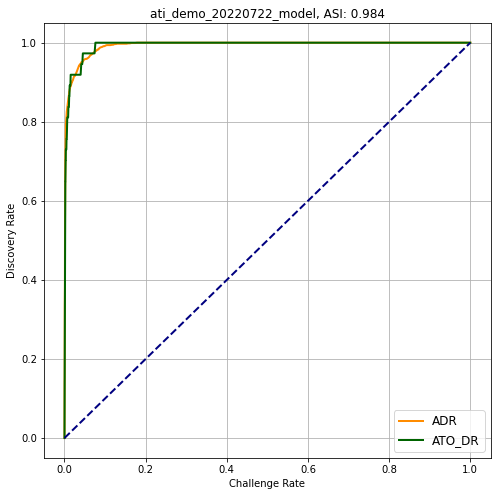

In [7]:
# -- model performance summary -- 
trainingMetrics = client.describe_model_versions(
    modelId            = MODEL_NAME,
    modelVersionNumber = model_version,
    modelType          = MODEL_TYPE,
    maxResults         = 10
)['modelVersionDetails'][0]['trainingResultV2']['trainingMetricsV2']['ati']

perf_asi = trainingMetrics['modelPerformance']['asi']
df_model = pd.DataFrame(trainingMetrics['metricDataPoints'])

# -- ROC Chart -- 
plt.figure(figsize = (8,8))
plt.plot(df_model["cr"], df_model["adr"], color='darkorange', lw=2, label='ADR')
plt.plot(df_model["cr"], df_model["atodr"], color='darkgreen', lw=2, label='ATO_DR')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Challenge Rate')
plt.ylabel('Discovery Rate')
plt.title(f'{MODEL_NAME}, ASI: {perf_asi:.3f}')
plt.legend(loc="lower right", fontsize=12)
plt.grid()
plt.show()

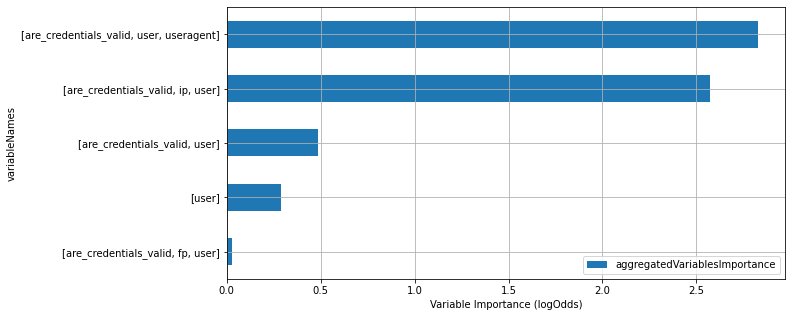

In [8]:
# -- variable importance summary -- 
varImpMetrics = client.describe_model_versions(
    modelId            = MODEL_NAME,
    modelVersionNumber = model_version,
    modelType          = MODEL_TYPE,
    maxResults         = 10
)['modelVersionDetails'][0]['trainingResultV2']['aggregatedVariablesImportanceMetrics'] 

df_var_imp = pd.DataFrame(varImpMetrics['logOddsMetrics']).sort_values(by='aggregatedVariablesImportance')

# -- Variable importance Chart -- 
df_var_imp.plot.barh(x='variableNames',y='aggregatedVariablesImportance',figsize=(10,int(df_var_imp.shape[0])))
plt.xlabel('Variable Importance (logOdds)')
plt.grid()
plt.show()

### 7. Create a Fraud Detector, generate Rules and assemble your Detector <a id = create_detector></a>
-----
The following section will automatically generate a number of fraud, investigate and approve rules based on the false positive rate and score thresholds of your model. These are just example rules that you could create, it is recommended that you fine tune your rules specifically to your business use case.  
    
<div class="alert alert-info"> 💡 <strong> Key APIs for Generating Rules, Creating and Publishing a Detector </strong>
    
- **put_detector**: Creates or updates a detector
- **put_outcome**: Creates or updates an outcome
- **create_rule**: Creates a rule for use with the specified detector
- **update_rule_version**: Updates a rule version resulting in a new rule version (version 1, 2, 3 ...)
- **create_detector_version**: Creates a detector version. The detector version starts in a DRAFT status
- **update_detector_version**: Updates a detector version. The detector version attributes that you can update include models, external model endpoints, rules, rule execution mode, and description. You can only update a DRAFT detector version
- **update_detector_version_status**: Updates the detector version’s status. You can perform the following promotions or demotions using UpdateDetectorVersionStatus: DRAFT to ACTIVE, ACTIVE to INACTIVE, and INACTIVE to ACTIVE
- **describe_detector**: Gets all versions for a specified detector
</div>

In [9]:
# -- put detector, initalizes your detector -- 
response = client.put_detector(
    detectorId    = DETECTOR_NAME, 
    description   = DETECTOR_DESC,
    eventTypeName = EVENT_TYPE )

In [10]:
# -- check the score thresholds with FPR from 1% to 6% --
model_stat = df_model.sort_values(by='cr')
model_stat['cr_bin']=np.ceil(model_stat['cr']*100)*0.01
m = model_stat.loc[model_stat.groupby(["cr_bin"])["threshold"].idxmin()] 
m = m.round(decimals=2)[['cr','adr','atodr','threshold']]
print (" --- score thresholds 1% to 6% --- ")
print(m.loc[(m['cr'] > 0.0 ) & (m['cr'] <= 0.06)].reset_index(drop=True))

 --- score thresholds 1% to 6% --- 
     cr   adr  atodr  threshold
0  0.01  0.86   0.84      750.0
1  0.02  0.90   0.92      670.0
2  0.03  0.92   0.92      620.0
3  0.04  0.95   0.92      575.0
4  0.05  0.96   0.97      540.0
5  0.06  0.96   0.97      515.0


In [ ]:
# -- decide what threshold and corresponding outcome you want to add -- 
# here, we create three simple rules by cutting the score at [950,750], 
# and create three outcome ['investigate', 'challenge', 'approve'] 
# it will create 3 rules:
#    score > 950: investigate
#    score > 750: challenge 
#    score <= 750: approve

score_cuts = [950,750]                          # Note: recommend to fine tune this based on your business use case
outcomes = ['investigate', 'challenge', 'approve']  # Note: recommend to define this based on your business use case

def create_outcomes(outcomes):
    """ 
    Create Fraud Detector Outcomes 
    """   
    for outcome in outcomes:
        print("creating outcome variable: {0} ".format(outcome))
        response = client.put_outcome(name = outcome, description = outcome)

def create_rules(score_cuts, outcomes):
    """
    Creating rules 
    
    Arguments:
        score_cuts  - list of score cuts to create rules
        outcomes    - list of outcomes associated with the rules
    
    Returns:
        a rule list to used when creating detector
    """
    
    if len(score_cuts)+1 != len(outcomes):
        logging.error('Your socre cuts and outcomes are not matched.')
    
    rule_list = []
    for i in range(len(outcomes)):
        # rule expression
        if i < (len(outcomes)-1):
            rule = "${0}_insightscore > {1}".format(MODEL_NAME,score_cuts[i])
        else:
            rule = "${0}_insightscore <= {1}".format(MODEL_NAME,score_cuts[i-1])
    
        # append to rule_list (used when create detector)
        rule_id = "rules{0}_{1}".format(i, MODEL_NAME)
        
        rule_list.append({
            "ruleId": rule_id, 
            "ruleVersion" : '1',
            "detectorId"  : DETECTOR_NAME
        })
        
        # create rules
        print("creating rule: {0}: IF {1} THEN {2}".format(rule_id, rule, outcomes[i]))
        try:
            response = client.create_rule(
                ruleId = rule_id,
                detectorId = DETECTOR_NAME,
                expression = rule,
                language = 'DETECTORPL',
                outcomes = [outcomes[i]]
                )
        except:
            print("this rule already exists in this detector")
            
    return rule_list
     
# -- create outcomes -- 
print(" -- create outcomes --")
create_outcomes(outcomes)

# -- create rules --
print(" -- create rules --")
rule_list = create_rules(score_cuts, outcomes)

In [ ]:
# -- create detector version --
client.create_detector_version(
    detectorId    = DETECTOR_NAME,
    rules         = rule_list,
    modelVersions = [{"modelId": MODEL_NAME, 
                      "modelType": MODEL_TYPE,
                      "modelVersionNumber": model_version}],
    # there are 2 options for ruleExecutionMode:
    #   'ALL_MATCHED'    - return all matched rules' outcome
    #   'FIRST_MATCHED'  - return first matched rule's outcome
    ruleExecutionMode = 'FIRST_MATCHED'
)

print("\n -- detector created -- ")
print(response) 

In [13]:
# -- activate the latest detector version --
detector_version_summaries = client.describe_detector(detectorId=DETECTOR_NAME)['detectorVersionSummaries']
latest_detector_version = max([det['detectorVersionId'] for det in detector_version_summaries])
print('Latest Detector Version:', latest_detector_version)

response = client.update_detector_version_status(
    detectorId        = DETECTOR_NAME,
    detectorVersionId = latest_detector_version,
    status            = 'ACTIVE'
)
print("\n -- detector activated -- ")
print(response)

Latest Detector Version: 1

 -- detector activated -- 
{'ResponseMetadata': {'RequestId': 'a1df5bee-a034-4459-886a-91d1c2c5d9da', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Fri, 22 Jul 2022 23:21:28 GMT', 'content-type': 'application/x-amz-json-1.1', 'content-length': '2', 'connection': 'keep-alive', 'x-amzn-requestid': 'a1df5bee-a034-4459-886a-91d1c2c5d9da'}, 'RetryAttempts': 0}}


### 8. Make predictions <a id=make_predictions></a>
-----

The following section will apply your detector to the latest 20% of your data to check the model performance. 

<div class="alert alert-info"> 💡 <strong> API for Making Predictions </strong>

- **get_event_prediction**: Evaluates an event against a detector version. If a version ID is not provided, the detector’s (ACTIVE) version is used.  


</div>


In [14]:
N_pred = 1000

In [29]:
%%time
def _predict(record):
    """
    Get prediction on one event
    """
    event_id = str(record[0])
    entity_id = str(record[1])
    event_timestamp = str(record[2])
    label_timestamp = str(record[4])
    
    try:
        rec_content = {event_variables[i]: str(record[5:][i]) for i in range(len(event_variables)) if pd.isnull(record[5+i])==False}
        pred = client.get_event_prediction(
            detectorId        = DETECTOR_NAME,
            detectorVersionId = latest_detector_version,
            eventId           = event_id,
            eventTypeName     = EVENT_TYPE,
            eventTimestamp    = event_timestamp, 
            entities          = [{
                'entityType': entity_type, 
                'entityId': entity_id
            }],
            eventVariables    = rec_content) 
        record.append(pred['modelScores'][0]['scores']["{0}_insightscore".format(MODEL_NAME)])
        record.append(pred['ruleResults'][0]['outcomes'])
    except:
        record.append("-999")
        record.append(["error"])
    
    return record

# -- get predictions in parallel --
if TRAINING_PERC < 1:
    df_test = df[df['EVENT_TIMESTAMP'] > test_split_time]
else: 
    # used all data to train the model, GEP on the last 100 events to demonstrate the API
    df_test = df.tail(100)

df_test = df_test.head(N_pred)
cols_keep = ['EVENT_ID', 'ENTITY_ID', 'EVENT_TIMESTAMP', 'EVENT_LABEL', 'LABEL_TIMESTAMP'] + event_variables
df_list = df_test[cols_keep].values.tolist()
with Pool(processes = 5) as p:
    result = p.map(_predict, df_list)
predictions = pd.DataFrame(result, columns = cols_keep + ['score', 'outcomes'])

CPU times: user 193 ms, sys: 107 ms, total: 301 ms
Wall time: 1min 59s


In [30]:
# -- check the first 5 rows --
predictions.head()

,EVENT_ID,ENTITY_ID,EVENT_TIMESTAMP,EVENT_LABEL,LABEL_TIMESTAMP,ip,useragent,fp,session_id,are_credentials_valid,score,outcomes
0,ev7fz3ebsvgs97,A3403324411,2022-05-27T21:56:54Z,NaN,NaN,142.135.19.20,Mozilla/5.0 (X11; Linux x86_64; rv:1.9.7.20) G...,FP-e156e30473ee46df,SID-98c30b09877d6031,True,432.0,[approve]
1,evhfmud6ke2enc,A7468806085,2022-05-27T21:56:59Z,NaN,NaN,177.186.170.126,Mozilla/5.0 (Macintosh; U; PPC Mac OS X 10_8_1...,FP-f54a5390ef306380,SID-274478ebb420a1fc,True,34.0,[approve]
2,ev8ea5sbd0r5c9,A0232763213,2022-05-27T21:57:32Z,NaN,NaN,27.238.226.94,Opera/9.85.(X11; Linux i686; ps-AF) Presto/2.9...,FP-c9a75b1f6054c108,SID-3b36e5cb3f499881,True,53.0,[approve]
3,evnqe2cutauoqx,A6099269191,2022-05-27T21:57:41Z,NaN,NaN,144.67.153.38,Mozilla/5.0 (iPhone; CPU iPhone OS 10_3_3 like...,FP-b4e68a1de7a0e00a,SID-41efa10b3354f9f2,True,831.0,[challenge]
4,evpl1oijpwktuv,A7415207154,2022-05-27T21:57:44Z,NaN,NaN,169.106.206.11,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_7_0)...,FP-ed13b8f486bc0b9f,SID-6bbfb3b371ddd3b3,True,178.0,[approve]


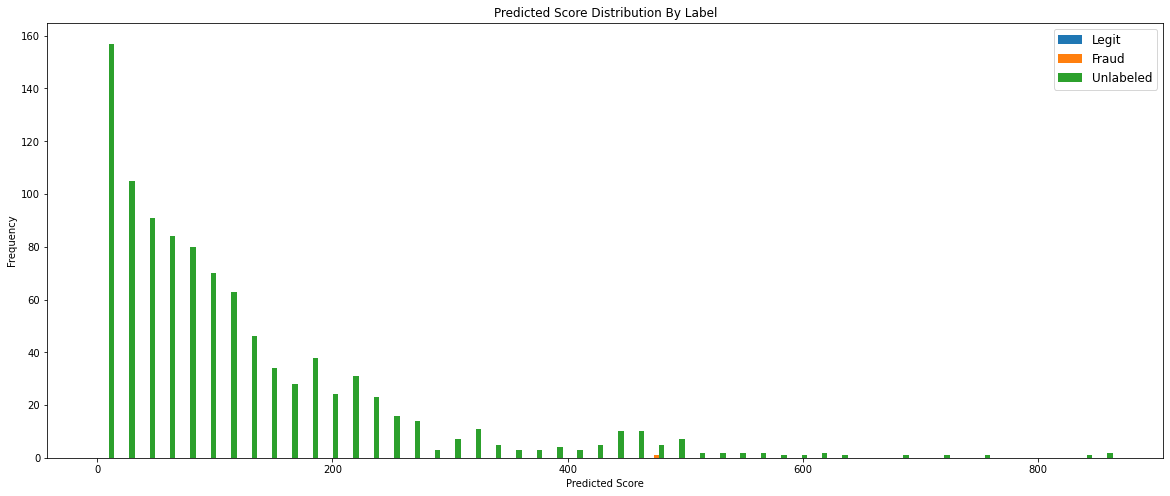

In [31]:
# -- check the distribution by labels --
plt.figure(figsize = (20,8))
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
plt.hist([predictions[predictions['EVENT_LABEL'].isin(label_mapper['LEGIT'])]['score'], 
          predictions[predictions['EVENT_LABEL'].isin(label_mapper['FRAUD'])]['score'], 
          predictions[predictions['EVENT_LABEL'].isna()]['score']], bins = 50)
plt.legend(["Legit", "Fraud", "Unlabeled"], fontsize=12)
plt.title("Predicted Score Distribution By Label")
plt.xlabel("Predicted Score")
plt.ylabel("Frequency")
plt.show()

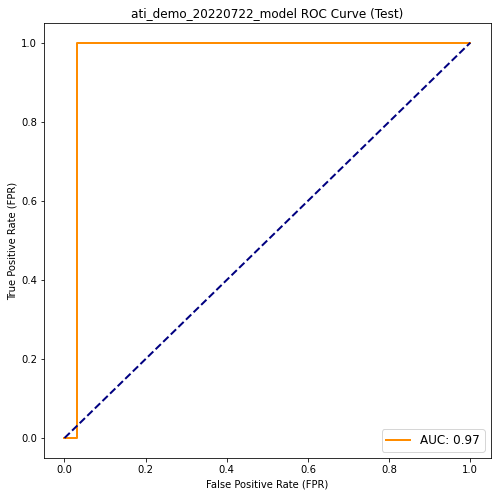

In [32]:
# -- check AUC --
predictions['event_label_int'] = np.nan
predictions.loc[predictions['EVENT_LABEL'].isna(), 'event_label_int'] = 0
predictions.loc[predictions['EVENT_LABEL'].isin(label_mapper['LEGIT']), 'event_label_int'] = 0
predictions.loc[predictions['EVENT_LABEL'].isin(label_mapper['FRAUD']), 'event_label_int'] = 1
                
fpr, tpr, threshold = roc_curve(predictions['event_label_int'], predictions['score'])
test_auc = auc(fpr,tpr)

plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"AUC: {test_auc:.2f}") 
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title(MODEL_NAME+" ROC Curve (Test)")
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (FPR)')
plt.legend(loc="lower right", fontsize=12)
plt.show()

### 9. Get reason codes for GEP calls


In [33]:
for eid in predictions['EVENT_ID'].head(1):
    # Retrieve event_prediction_time
    response = client.list_event_predictions(
        eventId={
            'value': eid
        },
        eventType={
            'value': EVENT_TYPE
        },
        detectorId={
            'value': DETECTOR_NAME
        },
        detectorVersionId={
            'value': latest_detector_version
        },
        predictionTimeRange={
            'startTime': '2022-01-01T00:00:00Z',
            'endTime': '2024-01-01T00:00:00Z'
        }
    )
    last_prediction_timestamp = response['eventPredictionSummaries'][-1]['predictionTimestamp']
    
    # Get event prediction explanations
    response = client.get_event_prediction_metadata(
        eventId=eid,
        eventTypeName=EVENT_TYPE,
        detectorId=DETECTOR_NAME,
        detectorVersionId=latest_detector_version,
        predictionTimestamp=last_prediction_timestamp
    )
    print('EVENT_ID: ', eid)
    print(pd.DataFrame(response['evaluatedModelVersions'][0]['evaluations'][0]['predictionExplanations']['aggregatedVariablesImpactExplanations']))

EVENT_ID:  ev7fz3ebsvgs97
                         eventVariableNames relativeImpact  logOddsImpact
0  [are_credentials_valid, user, useragent]              5       2.132089
1             [are_credentials_valid, user]              0       0.007980
2         [are_credentials_valid, fp, user]              0      -0.011876
3                                    [user]              0      -0.151291
4         [are_credentials_valid, ip, user]              5       3.638705


### (Optional) Write Predictions to File

<div class="alert alert-info"> 💡<strong> Write Predictions </strong>

- You can write your prediction dataset to a CSV to manually review predictions
- Simply add a cell below and copy the code below

</div>



```python

# -- optionally write predictions to a CSV file -- 
predictions.to_csv(MODEL_NAME + ".csv", index=False)
# -- or to a XLS file 
predictions.to_excel(MODEL_NAME + ".xlsx", index=False)

```

In [ ]:
# predictions.to_csv(MODEL_NAME + ".csv", index=False)

### (Optional) Clean up resources

In [ ]:
CLEAN_UP_RESOURCES = False

In [ ]:
if CLEAN_UP_RESOURCES:
    
    # Deactivate detector
    response = client.update_detector_version_status(
        detectorId=DETECTOR_NAME,
        detectorVersionId=latest_detector_version,
        status='INACTIVE'
    )

    # Delete detector version
    response = client.get_detector_version(
        detectorId=DETECTOR_NAME,
        detectorVersionId=latest_detector_version
    )
    print(f'De-activating detector {DETECTOR_NAME}')
    while response['status']=='ACTIVE':
        time.sleep(60)
        response = client.get_detector_version(
            detectorId=DETECTOR_NAME,
            detectorVersionId=latest_detector_version
        )
    response = client.delete_detector_version(
        detectorId=DETECTOR_NAME,
        detectorVersionId=latest_detector_version
    )
    print(f'Deleted detector {DETECTOR_NAME}, version {latest_detector_version}')

    # Delete rules
    rules = client.get_rules(
        detectorId=DETECTOR_NAME
    )
    for rule in rules['ruleDetails']:
        response = client.delete_rule(
            rule={
                'detectorId': DETECTOR_NAME,
                'ruleId': rule['ruleId'],
                'ruleVersion': rule['ruleVersion']
            }
        )
    print(f'Deleted rules of detector {DETECTOR_NAME}')

    # Delete Detector
    response = client.delete_detector(
        detectorId=DETECTOR_NAME
    )
    print(f'Deleted detector {DETECTOR_NAME}')

    # De-activate model version
    response = client.update_model_version_status(
        modelId=MODEL_NAME,
        modelType=MODEL_TYPE,
        modelVersionNumber=model_version,
        status='INACTIVE'
    )
    response = client.get_model_version(
        modelId=MODEL_NAME,
        modelType=MODEL_TYPE,
        modelVersionNumber=model_version
    )
    print(f'De-activating model {MODEL_NAME}')

    while response['status']!='TRAINING_COMPLETE':
        time.sleep(60)
        response = client.get_model_version(
            modelId=MODEL_NAME,
            modelType=MODEL_TYPE,
            modelVersionNumber=model_version
        )

    # Delete model version
    response = client.delete_model_version(
        modelId=MODEL_NAME,
        modelType=MODEL_TYPE,
        modelVersionNumber=model_version
    )

    # Delete model
    response = client.delete_model(
        modelId=MODEL_NAME,
        modelType=MODEL_TYPE
    )
    print(f'Deleted model {MODEL_NAME}')

    # Delete stored events
    response = client.delete_events_by_event_type(
        eventTypeName=EVENT_TYPE
    )
    response = client.get_delete_events_by_event_type_status(
        eventTypeName=EVENT_TYPE
    )
    while 'IN_PROGRESS' in response['eventsDeletionStatus']:
        time.sleep(60)
        print(f'Deleting event type: {EVENT_TYPE}')
        response = client.get_delete_events_by_event_type_status(
            eventTypeName=EVENT_TYPE
        )

    # Delete event type
    response = client.delete_event_type(
        name=EVENT_TYPE
    )
    print(f'Deleted event type {EVENT_TYPE}')